In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform
from gan.gan import Generator5Net, Discriminator5, train
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import GanPlotLossCallback as PlotLossCallback

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = 'data/img_align_celeba'
BATCH_SIZE = 512
NUM_WORKERS = 1
Z_SIZE = 100
MODEL_PATH = 'model/'
LOAD_MODEL = True
LOAD_EPOCH_N = 77
torch.cuda.set_device(0)

In [3]:

transform = ResizeTransform(path='data')
data = Data(DATA_PATH, Z_SIZE, transform)
data_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))


Dataset size:  202599


In [23]:
from inpainting.visualize import ConditionDescriptor
conditions = ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Wearing_Hat']
cd = ConditionDescriptor(conditions)
y = cd.create_condition(Young=True, Male=False, Smiling=True)
print(y)
print(y[cd.cond_dict['Eyeglasses']])
print(cd.describe(y))

{'Eyeglasses': 3, 'Smiling': 1, 'Young': 2, 'Wearing_Hat': 4, 'Male': 0}
[-1.  1.  1. -1. -1.]
-1.0
Smiling young woman 


In [4]:
generator = Generator5Net(Z_SIZE).cuda()
discriminator = Discriminator5().cuda()

In [5]:
print(generator)

Generator5Net(
  (layer0): Linear(in_features=100, out_features=16384, bias=True)
  (layer1): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), str

In [5]:
if LOAD_MODEL:
    generator.load_state_dict(torch.load(MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))

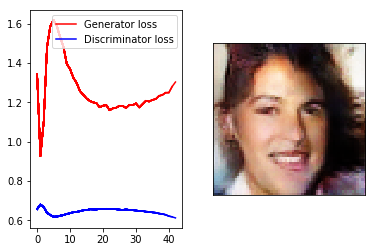

In [ ]:
callback = PlotLossCallback(generator, discriminator)
train(generator, discriminator, data_loader, 100, k=1, callback_func=callback, model_path=MODEL_PATH)


In [10]:

#print(Z)

tensor([[ 1.8307, -0.2602, -1.7820, -0.9923,  0.3051,  0.8523,  0.1468,
         -1.6428, -0.1286, -1.1731, -2.5091, -0.4575,  0.1769,  1.3189,
         -1.0830,  0.8586, -0.0031,  1.2339, -0.0026, -0.1130, -1.5624,
          0.8822, -1.2263,  0.4550, -2.0632,  0.4783, -2.7451,  0.9911,
         -0.3107, -1.6872, -0.2557,  0.9607, -0.8107, -0.8012, -2.2284,
          0.0102,  0.7794, -0.9828,  0.3473,  0.4681, -0.7351,  1.0933,
         -0.0636, -0.1289,  1.7876,  0.0795, -1.0996,  1.2146,  0.9892,
         -1.2441,  0.2528, -0.8565,  0.6095,  0.4950,  0.5277, -1.7238,
         -1.8258,  0.3929,  0.0484,  2.5564,  0.4598,  0.0592, -2.5452,
          0.7219, -0.1022,  0.4436, -0.5843, -0.3153, -0.6031, -1.2584,
         -0.1151, -0.2073, -2.2004,  1.5587,  2.2979,  0.5019,  0.4290,
          0.1358,  0.8879, -1.2404, -0.6883,  1.4252,  0.3508, -0.0374,
         -1.9984, -0.3522,  0.2310, -0.4234, -1.9883,  1.9122, -0.9175,
          2.0863,  1.4500, -1.0468, -0.7860,  1.6368, -0.3341,  

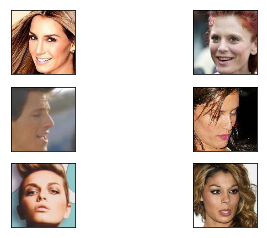

In [6]:
for batch, Z in data_loader:
    plot_batch((batch.data.cpu().numpy() + 1)/2, limit=6)
    break

[[ 0.12794453  0.25390577  0.050417   ...  0.15416683 -0.00315512
   0.12889752]]


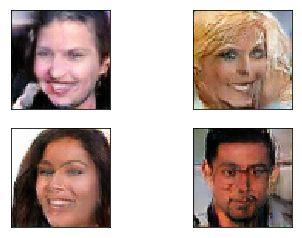

In [13]:
Z = torch.normal(mean=torch.zeros(4, generator.z_size)).cuda()
G_sample = generator(Z)
sample = G_sample.data.cpu().numpy()
print(discriminator.layer4.weight.cpu().detach().numpy())
plot_batch((G_sample.data.cpu().numpy() + 1) / 2)

In [14]:
w = generator.layer3[0].weight.data.cpu().numpy()
print(w)

RuntimeError: cuda runtime error (4) : unspecified launch failure at /pytorch/aten/src/THC/generic/THCTensorCopy.c:70

In [ ]:
for batch, Z in data_loader:
    X = batch.cuda()
    Z = Z.cuda()
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(X)
    D_fake, D_logit_fake = discriminator(G_sample)
    print('D_real', D_real,'\n', 'D_fake', D_fake)
    print('D_logit_real', D_logit_real, '\n', 'D_logit_fake', D_logit_fake)
    break
    